# Credit Card Fraud Detection

In this notebook we try to detect the fraudulent credit card transaction
### NOTE: Training Time
Execution time breakdown (initel i7 4 core 32Gb laptop)...
- EDA/Data Prep/Plots : **4 mins**
- Imbalanced Dataset modelling : **103 mins**
    - Logistic Regression : 30 Sec
    - Decision Tree       : 8 mins
    - Random Forest       : 51 mins
    - Linear SVM          : 21 mins
    - XGBoot              : 19 mins

- Balanced Dataset modelling, each algorithm has been run on 3 over-sampled datasets: **6 Hrs**
    - Logistic Regression : 2 * 3   = 6   mins
    - Decision Tree       : 3 * 20  = 60  mins
    - Random Forest       : 3 * 60  = 180 mins
    - Linear SVM          : 3 * 1.3 = 4   mins
    - XGBoot              : 3 * 37  = 110 mins


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import multiprocessing
print('No of CPU Cores: ' + str(multiprocessing.cpu_count()))

No of CPU Cores: 4


## 1. Exploratory data analysis

### 1.1 Load and inspect data


In [3]:
# from google.colab import drive
# drive.mount('drive')
# datafile = 'drive/My Drive/Data/creditcard.csv'

datafile = 'creditcard.csv'
df = pd.read_csv(datafile)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

> We observe above that there are no missing values. All columns are float except the 'target' column

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


> We observe above that all coulumns except 'Amount' and 'Time' are distributed around zero mean

### 1.2 Check Class Imbalance

In [6]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

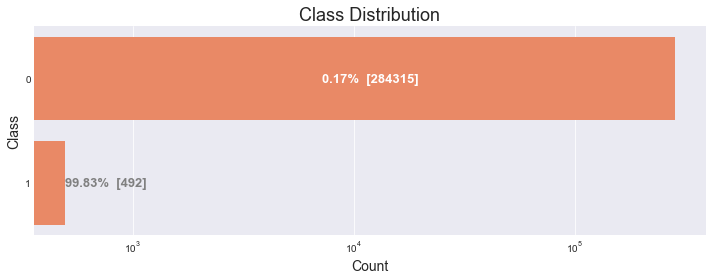

In [7]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=classes, y=classes.index, orient='h', ax=ax, color='coral')
ax.set_xscale('log'), 
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Class', fontsize=14)
ax.set(xscale='log', xlabel='Count', ylabel='Class')
ax.set_title('Class Distribution', fontsize=18)
bars = []
for patch in ax.patches:
    bars.append(patch)
ax.text(bars[0].get_width()/2 - 135000, bars[0].get_y()+0.43, 
        str(round(fraud_share, 2))+'%  '+'['+str(classes[0])+']', 
        fontsize=13, fontweight='bold', color='white')
ax.text(bars[1].get_width()+0.9, bars[1].get_y()+0.43, 
        str(round(normal_share, 2))+'%  '+'['+str(classes[1])+']', 
        fontsize=13, fontweight='bold', color='gray')
plt.tight_layout()
plt.show()

> As seen in above plot there is huge class imbalace between genuine and frauad cases. We'd need to tackle this issue before we build our models

### 1.3 Analyse predictors distribution 

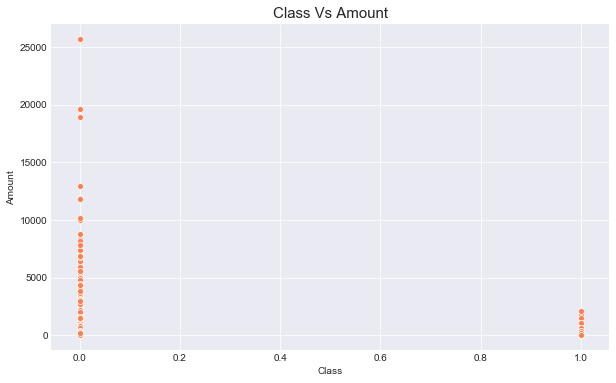

In [8]:
# Lets plot 'Class' against Amount
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df['Class'], y=df['Amount'], ax=ax, color='coral')
ax.set_title('Class Vs Amount', fontsize=15)
plt.show()

> We observe above that majority of ligitimate transactions are < 10000, there are quite a few outliers present. The fraud cases on the other hand are less in number and in amount as well, mostly < 2000. 

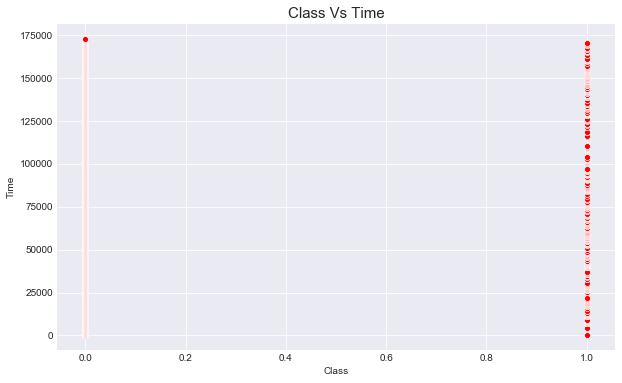

In [9]:
# Lets plot 'Class' against Time
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df['Class'], y=df['Time'], ax=ax, color='red')
ax.set_title('Class Vs Time', fontsize=15)
plt.show()

> We see above that here seems to be no particular pattern between time and the farudulent transactions, these are spread through out the two days period

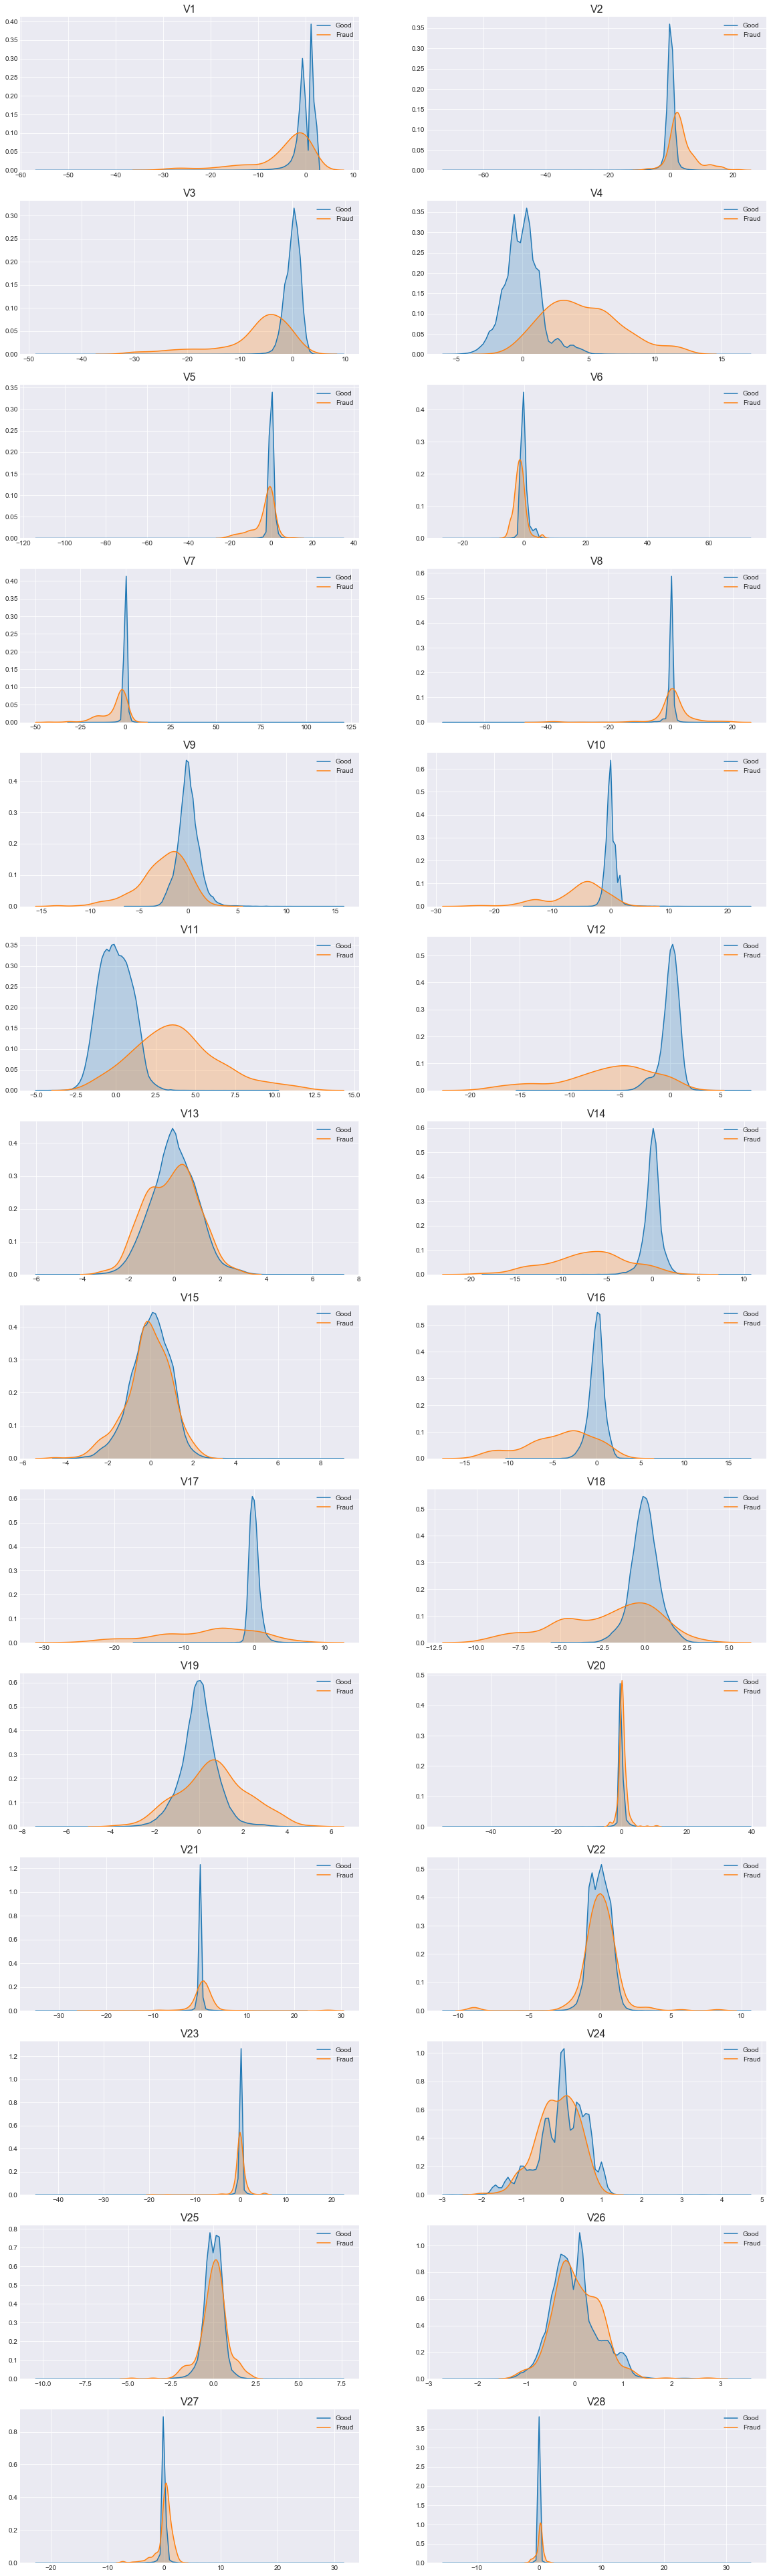

In [10]:
# Plot the distribution of each of PCA transformed columns (V1 to V28) for both classes
ncols = 2
nrows = 14
fig=plt.figure(figsize=(20, 14*5))
grid = plt.GridSpec(nrows, ncols, figure=fig)
i = 0
for i in range(1, 29):
    col = 'V'+str(i)
    good = df.loc[df.Class == 0][col]
    fraud = df.loc[df.Class == 1][col]
    ax = plt.subplot(grid[i-1])
    ax = sns.kdeplot(good, shade=True)
    ax = sns.kdeplot(fraud, shade=True)
    ax.set_title(col, fontsize=16)
    plt.legend(labels=['Good', 'Fraud'])
plt.show()

> With above plots we observe that there are variable whose distribution is different between 'Good' and 'Fraud' transacton which effectively means that the value of these variable for a given transaction can give us very good indication if the transaction is likely to be fruad or not.
For example...
* `V2 & V6`: The good transaction values are centered around zero and mostly ranges between -5 to 5. Whereas fraud transaction values is right skewed and ranges from -5 to 25 
* `V3 & V5`: The good transaction values are centered around zero and mostly ranges between -5 to 5. Whereas fraud transaction values is left skewed and ranges from -35 to 5 
* `V15 & V17`: We see that these variables are almost overlaps and identical for both Good and Fraud transaction. Which mean these variables are NOT likely to help us in differentiate between Goos and Fraud transactions.

> When we go through similar excericise for all 28 PCA variables we find that below listed variables are likely to be good predictors.
We'll use them in modelling... 
* `V1, V2,  V3, V4, V5, V6, V9, V10, V11, V12, V13, V14, V16, V17, V18, V19, V20, V21`
We'll discard rest of the PCA variables from modelling phase.

> From Scatter plot between "Amount Vs Class" and "Time Vs Class" we have concluded `Amount` could be an useful 
predictor however `Time` is not showing


## 2 Data Preparation

### 2.1 Drop unnecessary columns

In [11]:
# Drop unnecessary columns
drop_cols = ['Time', 'V7', 'V8', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
df = df.drop(drop_cols, axis=1)

### 2.2 Check Data Skewness

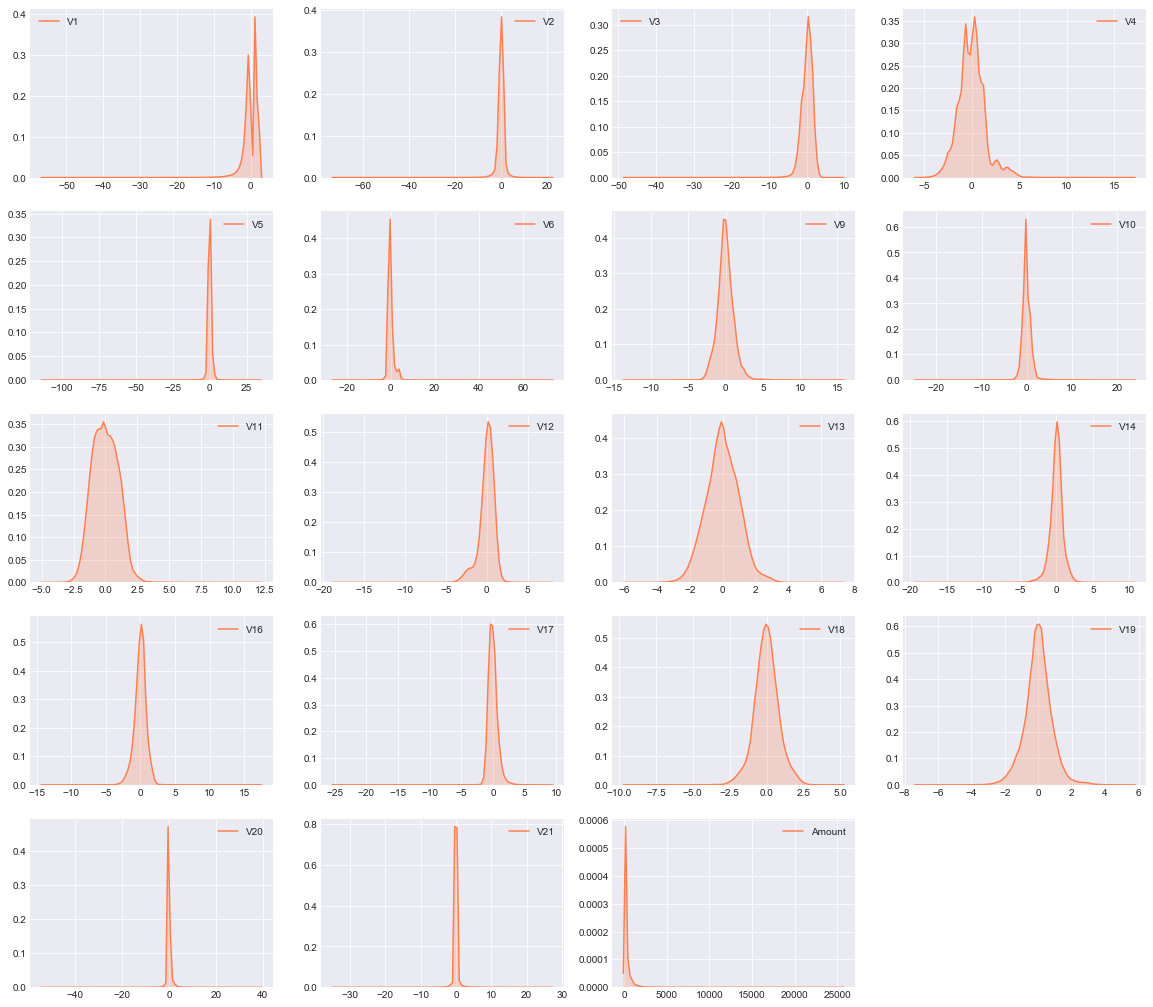

In [12]:
# Plot the distribution of independent variables from the dataset to see the skewness
ind_vars_df  = df.drop('Class', axis=1)

fig = plt.figure(figsize=(20, 18))
grid = plt.GridSpec(5, 4, figure=fig)
for i, col in enumerate(ind_vars_df.columns):
    ax = plt.subplot(grid[i])
    sns.kdeplot(ind_vars_df[col], shade=True, color='coral')
plt.show()

> We observe above that PCA transformed columns are normally distributed centered around zero. Few attributes such as V1 & V4 showing slight skewness.
'Amount' column is also right skewed. We'll need to handle this after we split the data in train and test.

### 2.3 Split the data into train & test data

In [13]:
X = df.drop('Class', axis=1)
y = df['Class']

In [14]:
from sklearn import model_selection

# Split the data in train and test
X_train, X_test, y_train, y_test =  model_selection.train_test_split(X, y, test_size=0.2, 
                                                                     random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(227845, 19) (227845,) (56962, 19) (56962,)


In [15]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


### 2.4 Apply PowerTransformer to remove data skew

In [16]:
# User PowerTransformer to remove skewness
# fit & transform the train & test data
pt = preprocessing.PowerTransformer()
cols = X_train.columns
pt.fit(X_train)
X_train = pt.transform(X_train)
X_test = pt.transform(X_test)

In [17]:
# Convert numpy arrays to DataFrame for easy visualisation
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)
X_train.head()

,V1,V2,V3,V4,V5,V6,V9,V10,V11,V12,V13,V14,V16,V17,V18,V19,V20,V21,Amount
0,1.336188,-0.544845,-0.965606,-0.420795,1.098808,2.530347,1.254348,-0.106992,-0.066314,0.455748,0.072358,-0.150225,0.352829,-0.924246,0.149650,-0.549506,-0.176355,0.122260,-0.604334
1,1.425774,-0.116737,-1.776576,0.252512,2.186342,2.157106,0.094536,0.304136,-0.208442,0.208679,-0.399209,0.766264,-0.892874,-0.359582,-0.834919,-0.329758,-0.296564,0.070475,-1.077975
2,-0.754387,0.330483,0.399881,-0.685256,-0.605729,1.414925,0.053256,-2.010828,-0.343141,2.650201,0.756416,0.056656,1.391102,-0.878343,0.156057,0.014625,1.674510,-4.186769,1.205799
3,1.686538,-0.960299,-0.630097,-1.249409,-1.008630,-0.179880,-1.042182,1.564049,0.137776,-0.866443,-0.463715,-0.285627,-0.153416,0.050786,0.916365,0.324058,-0.636737,-0.177824,-0.705232
4,-0.504203,-0.692345,-0.071695,-2.857635,0.512868,-0.008022,0.011243,-0.498444,-0.204561,-0.241971,-0.784132,0.069992,-2.148274,-0.509015,1.960380,-0.092901,-0.358673,-0.323872,0.809789


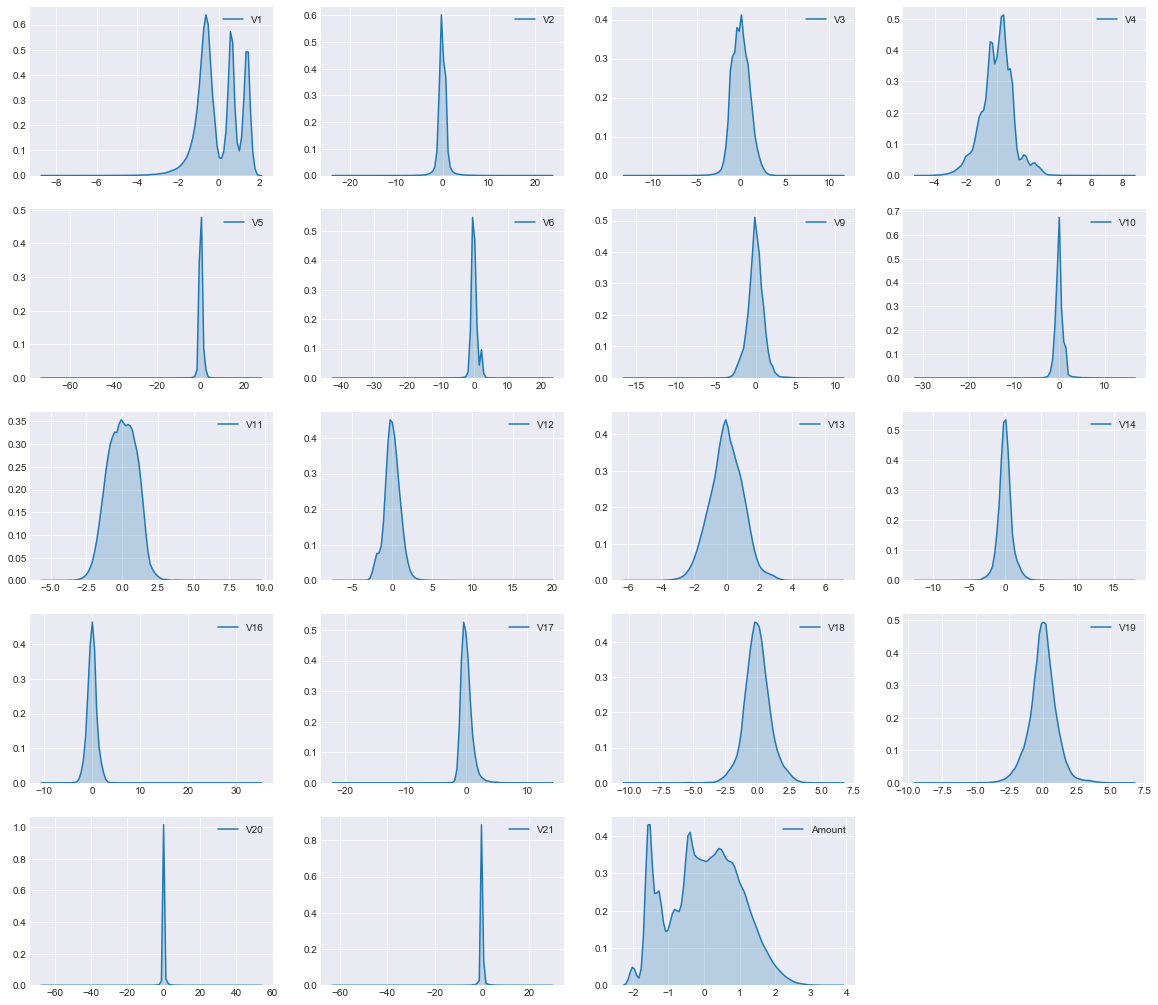

In [18]:
# Plot the distribution of variables again after above transformation 
fig = plt.figure(figsize=(20, 18))
grid = plt.GridSpec(5, 4, figure=fig)
for i, col in enumerate(cols):
    ax = plt.subplot(grid[i])
    sns.kdeplot(X_train[col], shade=True)
plt.show()

> We see above that all faetures are more or less Gaussian, specifically 'Amount' column has been standardized and looks like a Gaussian

## 3 Model Building - Imbalanced dataset
Build different models on the imbalanced dataset and see the result

In [19]:
# Metrics and best model of each type will be saved for latter comparison 
imbalanced_results = []
balanced_results = []

#
# Common utility functions to be used by all experiments below
#

# Function to visualise cross-validation results
def show_cv_metrics(model, model_name=None):
    results = model.cv_results_

    auc = np.nanmean(results['mean_train_AUC'])
    precision = np.nanmean(results['mean_train_Precision'])
    recall = np.nanmean(results['mean_train_Recall'])
    val_auc = np.nanmean(results['mean_test_AUC'])
    val_precision = np.nanmean(results['mean_test_Precision'])
    val_recall = np.nanmean(results['mean_test_Recall'])
    if not model_name: model_name = model.estimator.__class__.__name__

    heading_length = 100
    print()
    print('='*heading_length)
    print(f'CROSS VALIDATION METRICS : {model_name}')
    print('='*heading_length)
    print(f'Train AUC         : {auc*100:.2f}% | Val AUC: {val_auc*100:.2f}%')
    print(f'Train Precision   : {precision*100:.2f}% | Val Precision: {val_precision*100:.2f}%')
    print(f'Train Recall      : {recall*100:.2f}% | Val Recall: {val_recall*100:.2f}%')
    print('-'*heading_length)
    print(f'Best Params       : {model.best_params_}')
    print(f'Best AUC Score    : {model.best_score_*100:.2f}%')
    print('='*heading_length)
    print()


# Function to visualise evalution results
def show_evaluation_metrics(fpr, tpr, auc_score, precision, recall, model_name):   
    # Plot ROC curve
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score*100:.2f}%)', linewidth=2, color='coral')
    plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', linewidth=2, color='black', label='Random')
    ax.set_title('ROC Curve', fontsize=16, fontweight=2)
    ax.set(xlabel='FPR', ylabel='TPR', xlim=[-0.02, 1.0], ylim=[-0.02, 1.0]) 
    plt.legend(fontsize=14)
    plt.show()

    # Print other metrics
    print()
    print('='*100)
    print(f'EVALUATION METRICS : {model_name}')
    print('='*100)
    print(f'AUC       : {auc_score*100:.2f}%')
    print(f'Precision : {precision*100:.2f}%' )
    print(f'Recall    : {recall*100:.2f}%')
    print('='*100)


# Function to cross-validate the passed model.
def cross_validate_and_print_metrics(clf, X, y,  params, folds=5, verbose=False, model_name=None):
    metrics = {'AUC':make_scorer(roc_auc_score),
               'Precision': make_scorer(precision_score),
               'Recall':make_scorer(recall_score)}
    
    # Note that if cv is set to integer value and estimator is a classifier, which is the case here,
    # then sklearn uses StratifiedKFold splitting which we need for imbalanced dataset
    cv_model = GridSearchCV(estimator=clf, 
                            param_grid=params, 
                            cv=folds, 
                            scoring=metrics, 
                            refit='AUC',
                            return_train_score=True,
                            verbose=verbose, 
                            n_jobs=-1)
    cv_model.fit(X, y)
    show_cv_metrics(cv_model, model_name)
    return cv_model.best_params_

# Function to evalute the model on test data and generate performance metrics
def evaluate_and_print_metrics(clf, X_test, y_test, model_name=None):
    # Evaluate the performance of the model on the test set
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    # Compute performance metrics
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    if not model_name: model_name = clf.__class__.__name__
    # Show evaluation results
    show_evaluation_metrics(fpr, tpr, auc_score, precision, recall, model_name)
    return [clf, model_name, auc_score, precision, recall]

### 3.1 LogisticRegression
Cross Validate/Tune Hyperparameter/Evaluate

In [ ]:
# Wrap the model building in afunctions so that we can use same code
# in next section where we try to build models after class balancing

def build_logit_classifier(X_train, y_train, X_test, y_test, model_name=None):
    # Instantiate the Classifier and cross validate
    # [For below configuration ruuning on full dataset it takes around 16.1 min to finish on 4core i7/32Gb machine]
    clf = LogisticRegression(random_state=42)
    params = {'C':[1.0, 0.5, 0.25], 'solver': ['lbfgs', 'liblinear']}
    best_params = cross_validate_and_print_metrics(clf, X_train, y_train, params, 
                                                   verbose=1, model_name=model_name)

    # Now fit and evalute the model on test data with best parameters obtained using cross-validation  
    clf = LogisticRegression(**best_params, random_state=42).fit(X_train, y_train)
    metrics = evaluate_and_print_metrics(clf, X_test, y_test, model_name=model_name)

    return metrics

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.5s finished



CROSS VALIDATION METRICS : LogisticRegression
Train AUC         : 82.40% | Val AUC: 81.91%
Train Precision   : 91.23% | Val Precision: 90.84%
Train Recall      : 64.82% | Val Recall: 63.83%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 0.25, 'solver': 'lbfgs'}
Best AUC Score    : 81.97%



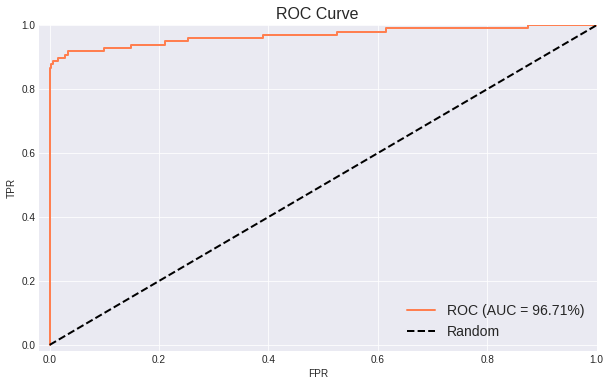


EVALUATION METRICS : LogisticRegression
AUC       : 96.71%
Precision : 82.05%
Recall    : 65.31%


In [52]:
#  Build the model and save the metrics obtained
results = build_logit_classifier(X_train, y_train, X_test, y_test)
imbalanced_results.append(results)

> ***Cross Validation*** : Train and Test metrics are very close to each other, model is not overfitting, we are getting an AUC of ~82% 
<br>***Evaluation*** : Good AUC and precision score but recall is on lower side
<br>

### 3.2 DecisionTree
Cross Validate/Tune Hyperparameter/Evaluate

In [ ]:
def build_decisiontree_classifier(X_train, y_train, X_test, y_test, model_name=None):
    # Instantiate the Classifier and cross validate 
    # [For below configuration ruuning on full dataset it takes around 4 min to finish on 4core i7/32Gb machine]
    clf = DecisionTreeClassifier(random_state=42)
    params = {'criterion':['gini', 'entropy'], 'max_depth': [5, 10, 20], 'min_samples_leaf': [2, 5, 7]}
    best_params = cross_validate_and_print_metrics(clf, X_train, y_train, params, 
                                                   verbose=1, model_name=model_name)

    # Now fit and evalute the model on test data with best parameters obtained using cross-validation  
    clf = DecisionTreeClassifier(**best_params, random_state=42).fit(X_train, y_train)
    metrics = evaluate_and_print_metrics(clf, X_test, y_test, model_name=model_name)

    return metrics

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.6min finished



CROSS VALIDATION METRICS : DecisionTreeClassifier
Train AUC         : 91.23% | Val AUC: 87.61%
Train Precision   : 94.68% | Val Precision: 86.60%
Train Recall      : 82.47% | Val Recall: 75.25%
----------------------------------------------------------------------------------------------------
Best Params       : {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
Best AUC Score    : 88.94%



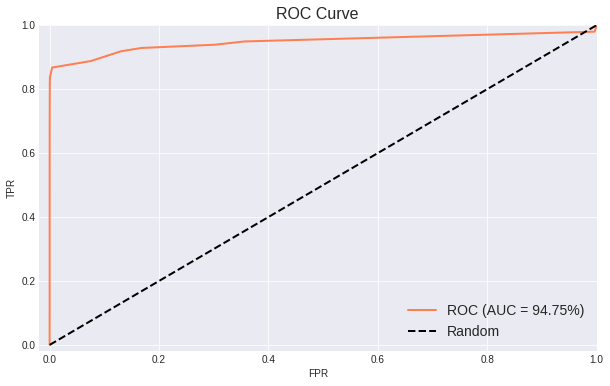


EVALUATION METRICS : DecisionTreeClassifier
AUC       : 94.75%
Precision : 83.33%
Recall    : 81.63%


In [54]:
#  Build the model and save the metrics obtained
results = build_decisiontree_classifier(X_train, y_train, X_test, y_test)
imbalanced_results.append(results)

> ***Cross Validation*** : Train and Test metrics are very close to each other, model is not overfitting, we are getting an AUC of ~88% 
<br>***Evaluation*** : Good AUC and precision score but recall is on lower side
<br>

### 3.3 RandomForestClassifier
Cross Validate/Tune Hyperparameter/Evaluate

In [20]:
def build_randomforest_classifier(X_train, y_train, X_test, y_test, model_name=None):
    # Instantiate the Classifier and cross validate
    # [For below configuration ruuning on full dataset it takes around 25 min to finish on 4core i7/32Gb machine]
    clf = RandomForestClassifier(random_state=42)
    params = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'min_samples_leaf': [2, 5]}
    best_params = cross_validate_and_print_metrics(clf, X_train, y_train, params, 
                                                   verbose=1, model_name=model_name)

    # Now fit and evalute the model on test data with best parameters obtained using cross-validation  
    clf = RandomForestClassifier(**best_params, random_state=42).fit(X_train, y_train)
    metrics = evaluate_and_print_metrics(clf, X_test, y_test, model_name=model_name)

    return metrics

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 51.8min finished



CROSS VALIDATION METRICS : RandomForestClassifier
Train AUC         : 89.51% | Val AUC: 87.19%
Train Precision   : 95.82% | Val Precision: 91.71%
Train Recall      : 79.03% | Val Recall: 74.39%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Best AUC Score    : 87.93%



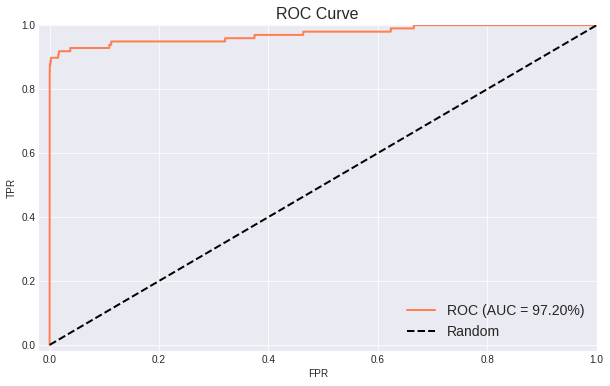


EVALUATION METRICS : RandomForestClassifier
AUC       : 97.20%
Precision : 95.18%
Recall    : 80.61%


In [103]:
# Build the model and save the metrics obtained
results = build_randomforest_classifier(X_train, y_train, X_test, y_test)
imbalanced_results.append(results)

> ***Cross Validation*** : Train and Test metrics are very close to each other, model is not overfitting, we are getting an AUC of ~88% 
<br>***Evaluation*** : Better AUC and precision score, recall also improved to 80% compare to DecisionTree
<br>

### 3.4 LinearSVC
Cross Validate/Tune Hyperparameter/Evaluate

In [21]:
def build_linearsvc_classifier(X_train, y_train, X_test, y_test, model_name=None):
    # Instantiate the Classifier and cross validate
    # [For below configuration ruuning on full dataset it takes around 1.5 min to finish on 4core i7/32Gb machine]
    clf = LinearSVC(random_state=42, max_iter=10000, dual=False)
    params = {'C':[0.09, 0.1, 0.3, 0.5, 1.0, 10, 20, 100]}
    best_params = cross_validate_and_print_metrics(clf, X_train, y_train, params, 
                                                   verbose=1, model_name=model_name)

    # Now fit and evalute the model on test data with best parameters obtained using cross-validation  
    clf = LinearSVC(**best_params, random_state=42, max_iter=10000, dual=False)
    clf = CalibratedClassifierCV(clf).fit(X_train, y_train)
    metrics = evaluate_and_print_metrics(clf, X_test, y_test, model_name=model_name)

    return metrics

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.2s finished



CROSS VALIDATION METRICS : LinearSVC
Train AUC         : 82.46% | Val AUC: 82.13%
Train Precision   : 89.50% | Val Precision: 89.40%
Train Recall      : 64.93% | Val Recall: 64.27%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 0.09}
Best AUC Score    : 82.22%



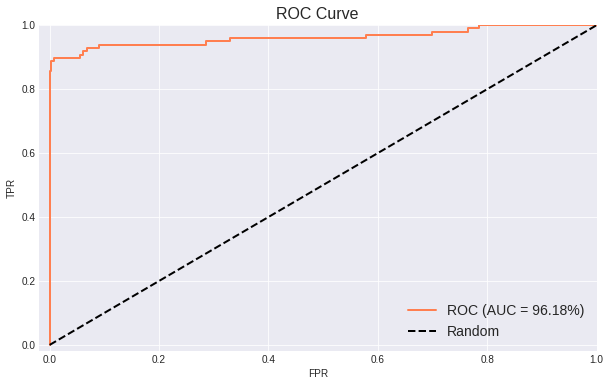


EVALUATION METRICS : LinearSVC
AUC       : 96.18%
Precision : 82.19%
Recall    : 61.22%


In [58]:
#  Build the model and save the metrics obtained
results = build_linearsvc_classifier(X_train, y_train, X_test, y_test, model_name='LinearSVC')
imbalanced_results.append(results)

> ***Cross Validation*** : Train and Test metrics are very close to each other, model is not overfitting, we are getting an AUC of ~82% 
<br>***Evaluation*** : AUC, precision, recall are lower than all three models built above ... LogisticRegression, DecisionTree & RandomForest
<br>

### 3.5 XGBoost
Cross Validate/Tune Hyperparameter/Evaluate

In [22]:
def build_xgboost_classifier(X_train, y_train, X_test, y_test, model_name=None):
    # Instantiate the Classifier and cross validate
    # [For below configuration ruuning on full dataset it takes around 19 min to finish on 4core i7/32Gb machine]
    clf = XGBClassifier(random_state=42, verbosity=0, tree_method='hist', booster='gbtree')
    params = {'n_estimators': [100, 200, 500], 'max_depth': [2, 3, 5], 'min_samples_leaf': [2, 3, 4]}
    best_params = cross_validate_and_print_metrics(clf, X_train, y_train, params, 
                                                   verbose=1, model_name=model_name)

    # Now fit the model again with best best parameters obtained using cross-validation  
    clf = XGBClassifier(**best_params, random_state=42, verbosity=0, 
                        tree_method='hist', booster='gbtree').fit(X_train, y_train)
    metrics = evaluate_and_print_metrics(clf, X_test, y_test, model_name=model_name)

    return metrics

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 19.2min finished



CROSS VALIDATION METRICS : XGBClassifier
Train AUC         : 93.95% | Val AUC: 88.75%
Train Precision   : 96.10% | Val Precision: 91.66%
Train Recall      : 87.90% | Val Recall: 77.51%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 500}
Best AUC Score    : 89.71%



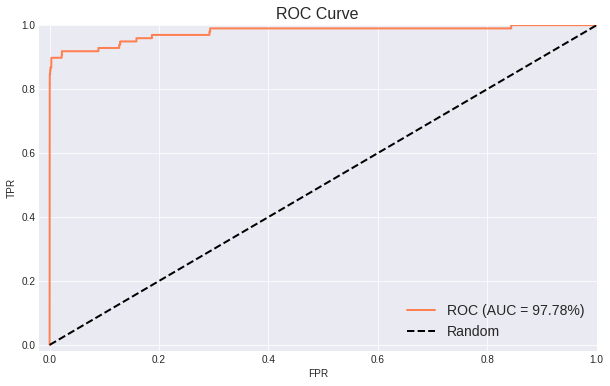


EVALUATION METRICS : XGBClassifier
AUC       : 97.78%
Precision : 91.67%
Recall    : 78.57%


In [61]:
#  Build the model and save the metrics obtained
results = build_xgboost_classifier(X_train, y_train, X_test, y_test)
imbalanced_results.append(results)

> ***Cross Validation*** : Train and Test metrics are very close to each other, model is not overfitting, we are getting an AUC of ~89% 
<br>***Evaluation*** : With XGBoost We are getting highest AUC (98%), precision (92%), recall (79%) among all models we trained.
<br>

### 3.6 Best Model - Selection
In section above we completed below activities..
- Cross Evaluted 5 different algorithms using 5 fold cross-validation on training data and each of the algorithms we found the 'best model hyperparameters'
- Fitted the model with 'best model hyperparameters' on training data to get best 5 five models 
- Saved the performance metrics for each of the best 5 models

In this section we'll... 
- Analyse the performance metrics and select the best model out of 5 best s-validated models

In [62]:
# Analyse the model metrics
metrics_df = pd.DataFrame([imbalanced_results[i][1:] for i in range(5)], 
                          columns=['Model', 'auc', 'precision', 'recall'])
metrics_df.iloc[:, 1:] = metrics_df.iloc[:, 1:].apply(lambda x: round(x*100, 2))
metrics_df['f1'] = round((2 * metrics_df.precision * metrics_df.recall)/(metrics_df.precision + metrics_df.recall), 2)
metrics_df.sort_values(by=['auc','f1'], ascending=False, inplace=True)
metrics_df

,Model,auc,precision,recall,f1
4,XGBClassifier,97.78,91.67,78.57,84.62
2,RandomForestClassifier,97.20,95.18,80.61,87.29
0,LogisticRegression,96.71,82.05,65.31,72.73
3,LinearSVC,96.18,82.19,61.22,70.17
1,DecisionTreeClassifier,94.75,83.33,81.63,82.47


> Aim of this project is to provide a means to catch potential fraudulent transactions. What this really means is...
* If we fail to identify a fraudulent transaction then it'd be costly miss.
* However if we incorrectly marked a genuine transaction as a fraud, even though this is a problem, it's impact is not as severe as missing to classify a fraudulent transaction<br><br>
Bsed on above principles our final model selection will mostly rely on...
* `Recall score`: Which tells us how good we are identifying a fraud which is indeed a fraud i.e. low 'Flase Negatives'
* `ROC AUC`: which tells us how effective our model is in minimizing 'False Positive Rate' i.e. less missclassification of negative cases and at the same time how effective the model is in maximizing the 'True Positive Rate' i.e. identification of real fraudulent transactions. This is nothing but recall (sensitivity)

> Now keeping above criterias in mind If we look at the metrics above we observe that...
* `LinearSVC` model stands most poorly among all models across all metrics. Hence we'll simply discard it from our list of potential models.
* `LogisticRegression` and `DecisionTreeClassifier` are almost compareable where DecisionTreeClassifier has significantly higher recall (~10%) compare to LogisticRegression. Given that their AUC score is very close to each other we tend to inclined towards choosing DecisionTreeClassifier over LogisticRegression even though LogisticRegression training timing is almost 10 times less than DecisionTreeClassifier training time.
* When we compare `RandomForestClassifier` with `DecisionTreeClassifier` we find that RandomForestClassifier is clear winner here out-scoring DecisionTreeClassifier across all metrics
* Finally when we compare `XGBClassifier` (XGBoost) with `RandomForestClassifier` we find that performance nearly comparable XGBClassifier has fractionally higher AUC but RandomForestClassifier has higher Recall & Precision hence f1. If we bring training time in to the mix we find that XGBClassifier trains almost 30% faster (19 min Vs 25 min) but since our aim is to identify real frauds and keep false alrams low we'll look at recall first and precision which makes RandomForestClassifier as our model of choice here.

#### Based on the above analysis and evalution we choose `RandomForestClassifier` as our final model to use with imbalanced dataset.

### 3.7 Best Model - Feature Importance 
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 14
2nd Top var = 10
3rd Top var = 12


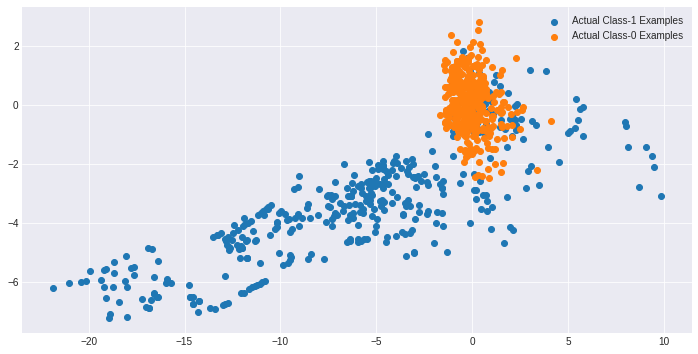

In [65]:
# RandomForestClassifier is our top tuned model, lets extract it from saved results
# Which is at index 2 (3rd item) in imbalanced_results list
clf = imbalanced_results[2][0]

var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-12 and Index-8 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

plt.figure(figsize=(12, 6))
plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## 4. Model building - Balanced Dataset

Perform class balancing with Random Oversampling SMOTE ADASYN before building various models

### 4.1 Class Balancing


In [23]:
# Function for generating balanced dataset with additinal samples based on method passed to it
def balance_dataset(using='RANDOM', dataset=(X, y)):
    sampler = None
    if using == 'SMOTE': 
        sampler = SMOTE(random_state=42)
    elif using == 'ADASYN':
        sampler = ADASYN(random_state=42)
    elif using == 'RANDOM':
        sampler = RandomOverSampler(random_state=42)

    X_train_sampled, y_train_sampled = sampler.fit_resample(X.to_numpy(), y.to_numpy())
    # Artificial minority samples and corresponding minority labels from sampling-method are appended
    # below X_train and y_train respectively
    # So to exclusively get the artificial minority samples from sampling-method, we do
    X_train_sampled_1 = X_train_sampled[X.shape[0]:]

    X_train_1 = X.to_numpy()[np.where(y==1.0)]
    X_train_0 = X.to_numpy()[np.where(y==0.0)]

    print()
    print(f'Data shape - Original      : X Shape: {X.shape} | y Shape: {y.shape}')
    print(f'Data shape - After sampling: X Shape: {X_train_sampled.shape} | y Shape: {y_train_sampled.shape}')
    print()
    fig = plt.figure(figsize=(10,8))
    plt.suptitle(f'Oversampling using {using} method', fontsize=18, fontweight=2)
    
    plt.subplot(3, 1, 1)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], 
                label='Actual Class-0 Examples', alpha=0.7)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], 
                label='Actual Class-0 Examples', alpha=0.8)
    plt.scatter(X_train_sampled_1[:X_train_1.shape[0], 0], X_train_sampled_1[:X_train_1.shape[0], 1],
                label=f'Artificial {using} Class-1 Examples', color='green', alpha=0.4)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return (X_train_sampled, y_train_sampled)

#### 4.1.1 Random Oversampling


Data shape - Original      : X Shape: (284807, 19) | y Shape: (284807,)
Data shape - After sampling: X Shape: (568630, 19) | y Shape: (568630,)



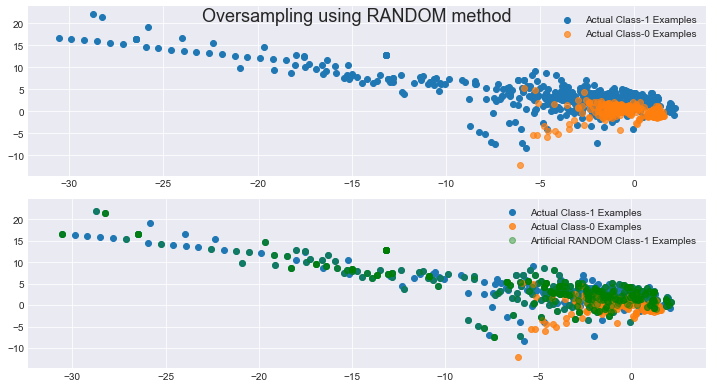

In [24]:
X_train_random, y_train_random = balance_dataset(using='RANDOM', dataset=(X_train, y_train))

#### 4.1.2 SMOTE Oversampling


Data shape - Original      : X Shape: (284807, 19) | y Shape: (284807,)
Data shape - After sampling: X Shape: (568630, 19) | y Shape: (568630,)



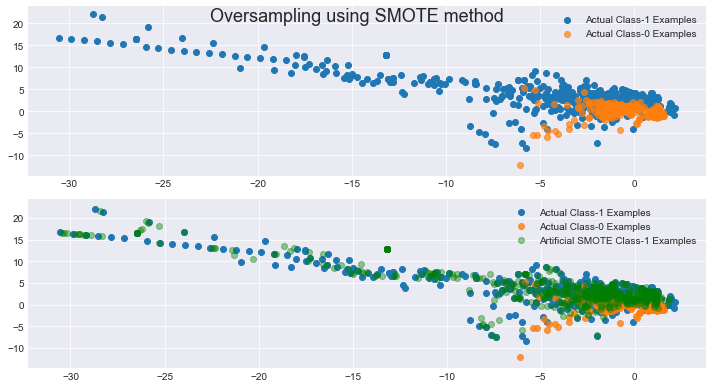

In [25]:
X_train_smote, y_train_smote = balance_dataset(using='SMOTE', dataset=(X_train, y_train))

#### 4.1.3 ADASYN Oversampling


Data shape - Original      : X Shape: (284807, 19) | y Shape: (284807,)
Data shape - After sampling: X Shape: (568720, 19) | y Shape: (568720,)



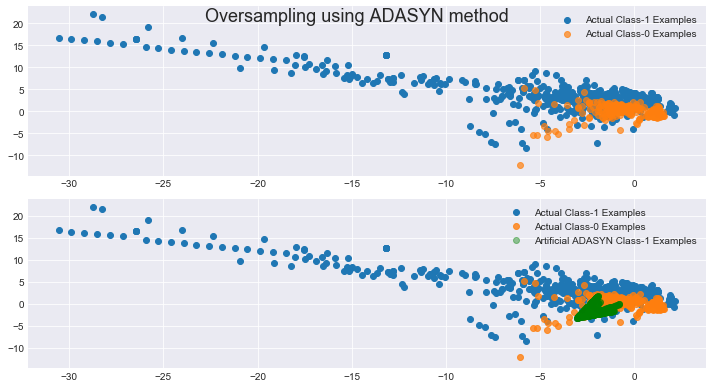

In [26]:
X_train_adasyn, y_train_adasyn = balance_dataset(using='ADASYN', dataset=(X_train, y_train))

### 4.2 LogisticRegression
Build model using on generated using above three different techniques and see which one yields better results. Cross validate models for each sampled dataset to tune hyperparameter to arrive at best model for the given sample dataset. We'll endup with 3 best models one for each of the sample datasets.

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished



CROSS VALIDATION METRICS : LogisticRegression_RANDOM
Train AUC         : 94.37% | Val AUC: 94.12%
Train Precision   : 97.40% | Val Precision: 96.89%
Train Recall      : 91.17% | Val Recall: 91.16%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 1.0, 'solver': 'liblinear'}
Best AUC Score    : 94.14%



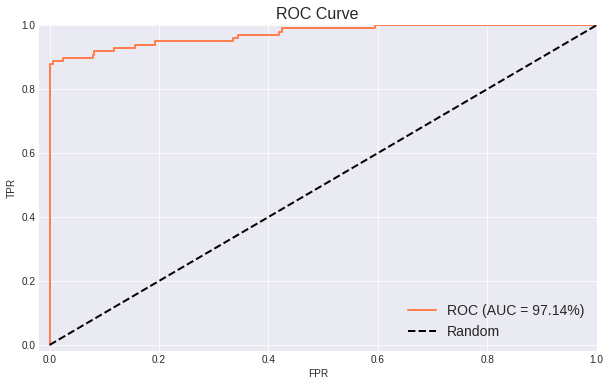


EVALUATION METRICS : LogisticRegression_RANDOM
AUC       : 97.14%
Precision : 10.56%
Recall    : 88.78%


In [71]:
####  Build the model and save the metrics obtained with RANDOM sampling
results = build_logit_classifier(X_train_random, y_train_random, 
                                 X_test, y_test, model_name='LogisticRegression_RANDOM')
balanced_results.append(results)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished



CROSS VALIDATION METRICS : LogisticRegression_SMOTE
Train AUC         : 95.71% | Val AUC: 95.47%
Train Precision   : 98.05% | Val Precision: 97.56%
Train Recall      : 93.28% | Val Recall: 93.27%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 0.5, 'solver': 'liblinear'}
Best AUC Score    : 95.48%



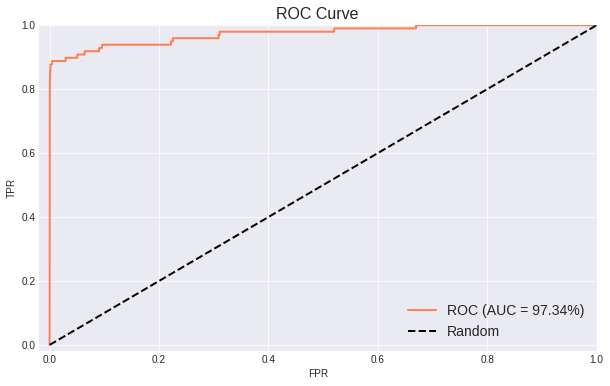


EVALUATION METRICS : LogisticRegression_SMOTE
AUC       : 97.34%
Precision : 15.65%
Recall    : 88.78%


In [72]:
#  Build the model and save the metrics obtained with SMOTE sampling
results = build_logit_classifier(X_train_smote, y_train_smote, 
                                 X_test, y_test, model_name='LogisticRegression_SMOTE')
balanced_results.append(results)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished



CROSS VALIDATION METRICS : LogisticRegression_ADASYN
Train AUC         : 91.08% | Val AUC: 90.56%
Train Precision   : 93.91% | Val Precision: 93.36%
Train Recall      : 87.86% | Val Recall: 87.39%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 1.0, 'solver': 'liblinear'}
Best AUC Score    : 90.59%



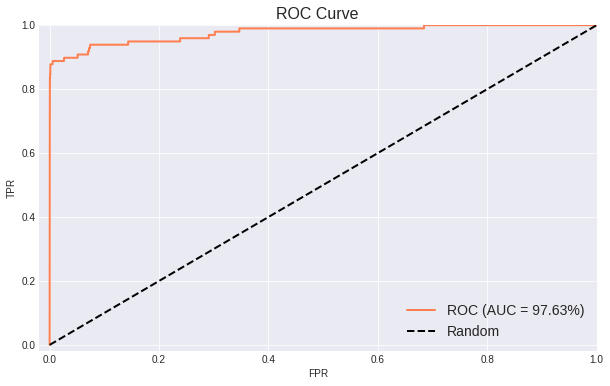


EVALUATION METRICS : LogisticRegression_ADASYN
AUC       : 97.63%
Precision : 5.10%
Recall    : 89.80%


In [73]:
#  Build the model and save the metrics obtained with ADASYS sampling
results = build_logit_classifier(X_train_adasyn, y_train_adasyn, 
                                 X_test, y_test, model_name='LogisticRegression_ADASYN')
balanced_results.append(results)

### 4.3 DecisionTree
Build model using on generated using above three different techniques and see which one yields better results. Cross validate models for each sampled dataset to tune hyperparameter to arrive at best model for the given sample dataset. We'll endup with 3 best models one for each of the sample datasets.

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.8min finished



CROSS VALIDATION METRICS : DecisionTreeClassifier_RANDOM
Train AUC         : 98.46% | Val AUC: 98.28%
Train Precision   : 98.87% | Val Precision: 98.50%
Train Recall      : 98.03% | Val Recall: 98.03%
----------------------------------------------------------------------------------------------------
Best Params       : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2}
Best AUC Score    : 99.93%



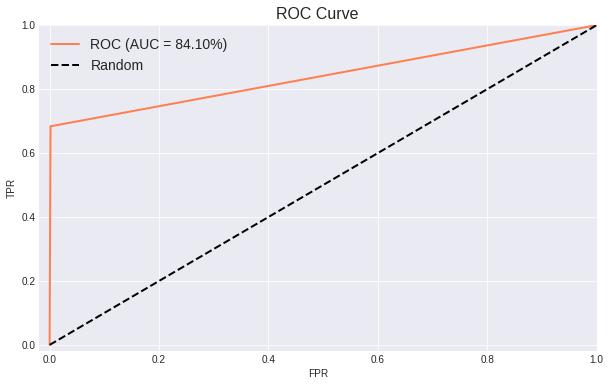


EVALUATION METRICS : DecisionTreeClassifier_RANDOM
AUC       : 84.10%
Precision : 41.61%
Recall    : 68.37%


In [74]:
#  Build the model and save the metrics obtained with RANDOM sampling
results = build_decisiontree_classifier(X_train_random, y_train_random, 
                                        X_test, y_test, model_name='DecisionTreeClassifier_RANDOM')
balanced_results.append(results)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 21.4min finished



CROSS VALIDATION METRICS : DecisionTreeClassifier_SMOTE
Train AUC         : 98.23% | Val AUC: 97.95%
Train Precision   : 98.60% | Val Precision: 98.12%
Train Recall      : 97.84% | Val Recall: 97.77%
----------------------------------------------------------------------------------------------------
Best Params       : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2}
Best AUC Score    : 99.78%



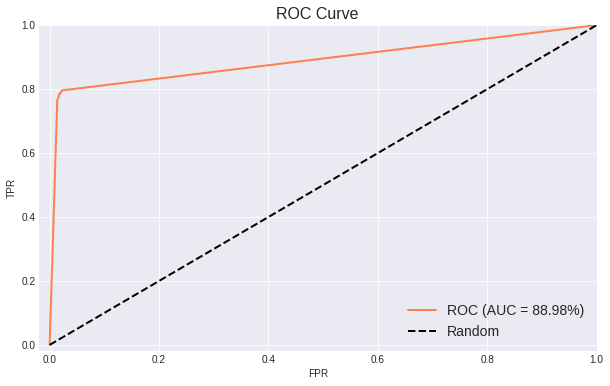


EVALUATION METRICS : DecisionTreeClassifier_SMOTE
AUC       : 88.98%
Precision : 6.56%
Recall    : 78.57%


In [75]:
#  Build the model and save the metrics obtained with SMOTE sampling
results = build_decisiontree_classifier(X_train_smote, y_train_smote, 
                                        X_test, y_test, model_name='DecisionTreeClassifier_SMOTE')
balanced_results.append(results)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 21.5min finished



CROSS VALIDATION METRICS : DecisionTreeClassifier_ADASYN
Train AUC         : 97.14% | Val AUC: 93.97%
Train Precision   : 97.02% | Val Precision: 96.18%
Train Recall      : 97.26% | Val Recall: 91.64%
----------------------------------------------------------------------------------------------------
Best Params       : {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2}
Best AUC Score    : 96.04%



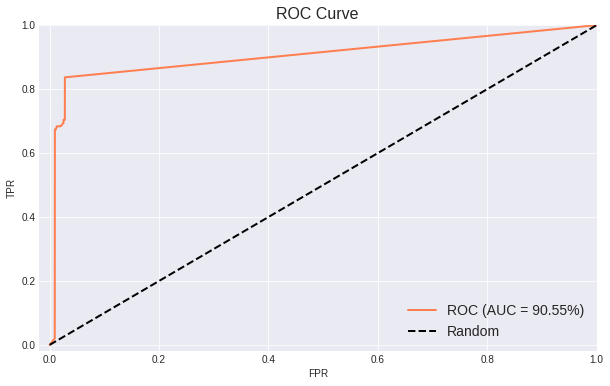


EVALUATION METRICS : DecisionTreeClassifier_ADASYN
AUC       : 90.55%
Precision : 4.56%
Recall    : 70.41%


In [76]:
#  Build the model and save the metrics obtained with ADASYN sampling
results = build_decisiontree_classifier(X_train_adasyn, y_train_adasyn, 
                                        X_test, y_test, model_name='DecisionTreeClassifier_ADASYN')
balanced_results.append(results)

### 4.4 RandomForestClassifier
Build model using on generated using above three different techniques and see which one yields better results. Cross validate models for each sampled dataset to tune hyperparameter to arrive at best model for the given sample dataset. We'll endup with 3 best models one for each of the sample datasets.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 45.6min finished



CROSS VALIDATION METRICS : RandomForestClassifier_RANDOM
Train AUC         : 97.49% | Val AUC: 97.47%
Train Precision   : 99.79% | Val Precision: 99.74%
Train Recall      : 95.18% | Val Recall: 95.18%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Best AUC Score    : 99.45%



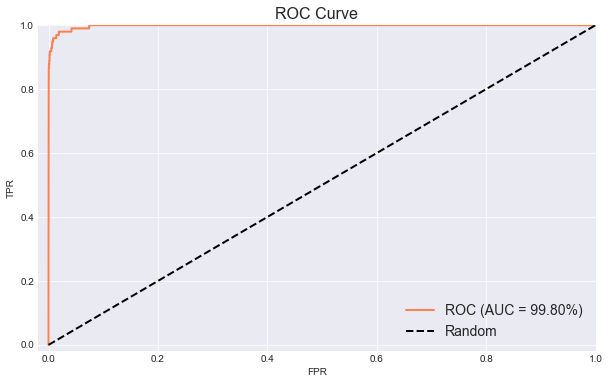


EVALUATION METRICS : RandomForestClassifier_RANDOM
AUC       : 99.80%
Precision : 76.15%
Recall    : 84.69%


In [33]:
#  Build the model and save the metrics obtained with RANDOM sampling
results = build_randomforest_classifier(X_train_random, y_train_random, 
                                        X_test, y_test, model_name='RandomForestClassifier_RANDOM')
balanced_results.append(results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 72.6min finished



CROSS VALIDATION METRICS : RandomForestClassifier_SMOTE
Train AUC         : 97.22% | Val AUC: 97.15%
Train Precision   : 99.67% | Val Precision: 99.57%
Train Recall      : 94.75% | Val Recall: 94.70%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Best AUC Score    : 98.83%



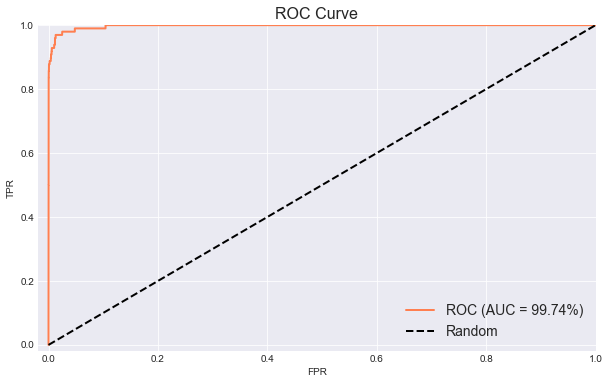


EVALUATION METRICS : RandomForestClassifier_SMOTE
AUC       : 99.74%
Precision : 37.02%
Recall    : 88.78%


In [30]:
#  Build the model and save the metrics obtained with SMOTE sampling
results = build_randomforest_classifier(X_train_smote, y_train_smote, 
                                        X_test, y_test, model_name='RandomForestClassifier_SMOTE')
balanced_results.append(results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 72.6min finished



CROSS VALIDATION METRICS : RandomForestClassifier_ADASYN
Train AUC         : 96.68% | Val AUC: 94.13%
Train Precision   : 98.33% | Val Precision: 98.04%
Train Recall      : 94.94% | Val Recall: 90.04%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}
Best AUC Score    : 96.31%



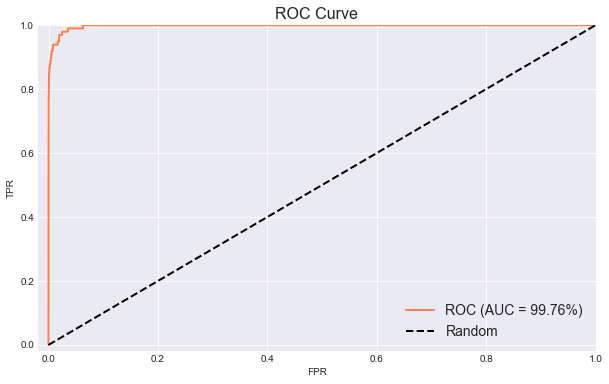


EVALUATION METRICS : RandomForestClassifier_ADASYN
AUC       : 99.76%
Precision : 11.11%
Recall    : 93.88%


In [34]:
#  Build the model and save the metrics obtained with ADASYN sampling
results = build_randomforest_classifier(X_train_adasyn, y_train_adasyn, 
                                        X_test, y_test, model_name='RandomForestClassifier_ADASYN')
balanced_results.append(results)

### 4.5 LinearSVC
Build model using on generated using above three different techniques and see which one yields better results. Cross validate models for each sampled dataset to tune hyperparameter to arrive at best model for the given sample dataset. We'll endup with 3 best models one for each of the sample datasets.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished



CROSS VALIDATION METRICS : LinearSVC_RANDOM
Train AUC         : 94.28% | Val AUC: 94.10%
Train Precision   : 97.88% | Val Precision: 97.51%
Train Recall      : 90.51% | Val Recall: 90.52%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 20}
Best AUC Score    : 94.10%



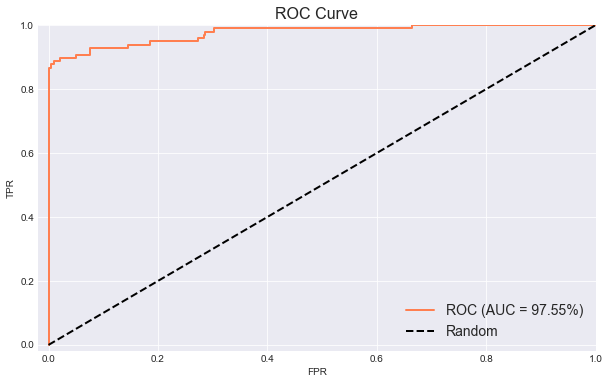


EVALUATION METRICS : LinearSVC_RANDOM
AUC       : 97.55%
Precision : 10.88%
Recall    : 88.78%


In [38]:
#  Build the model and save the metrics obtained with RANDOM sampling
results = build_linearsvc_classifier(X_train_random, y_train_random, 
                                     X_test, y_test, model_name='LinearSVC_RANDOM')
balanced_results.append(results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished



CROSS VALIDATION METRICS : LinearSVC_SMOTE
Train AUC         : 95.49% | Val AUC: 95.34%
Train Precision   : 98.45% | Val Precision: 98.11%
Train Recall      : 92.44% | Val Recall: 92.45%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 0.5}
Best AUC Score    : 95.34%



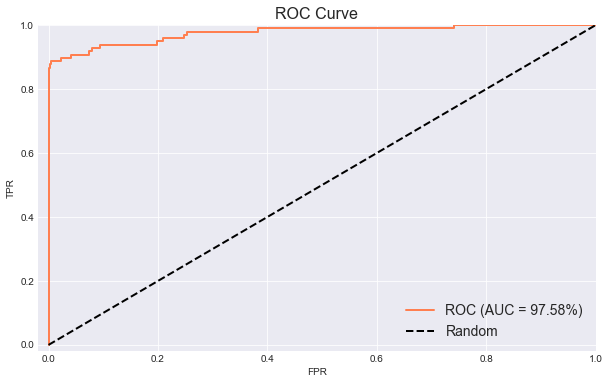


EVALUATION METRICS : LinearSVC_SMOTE
AUC       : 97.58%
Precision : 18.87%
Recall    : 88.78%


In [39]:
#  Build the model and save the metrics obtained with SMOTE sampling
results = build_linearsvc_classifier(X_train_smote, y_train_smote, 
                                     X_test, y_test, model_name='LinearSVC_SMOTE')
balanced_results.append(results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished



CROSS VALIDATION METRICS : LinearSVC_ADASYN
Train AUC         : 90.79% | Val AUC: 90.39%
Train Precision   : 94.41% | Val Precision: 94.04%
Train Recall      : 86.72% | Val Recall: 86.30%
----------------------------------------------------------------------------------------------------
Best Params       : {'C': 100}
Best AUC Score    : 90.40%



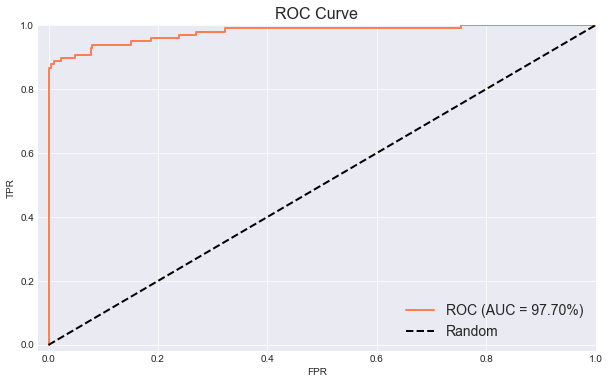


EVALUATION METRICS : LinearSVC_ADASYN
AUC       : 97.70%
Precision : 5.46%
Recall    : 89.80%


In [40]:
#  Build the model and save the metrics obtained with ADASYN sampling
results = build_linearsvc_classifier(X_train_adasyn, y_train_adasyn, 
                                     X_test, y_test, model_name='LinearSVC_ADASYN')
balanced_results.append(results)

### 4.6 XGBoost
Build model using on generated using above three different techniques and see which one yields better results. Cross validate models for each sampled dataset to tune hyperparameter to arrive at best model for the given sample dataset. We'll endup with 3 best models one for each of the sample datasets.

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 39.2min finished



CROSS VALIDATION METRICS : XGBClassifier_RANDOM
Train AUC         : 99.18% | Val AUC: 99.07%
Train Precision   : 99.49% | Val Precision: 99.28%
Train Recall      : 98.85% | Val Recall: 98.85%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 500}
Best AUC Score    : 99.98%



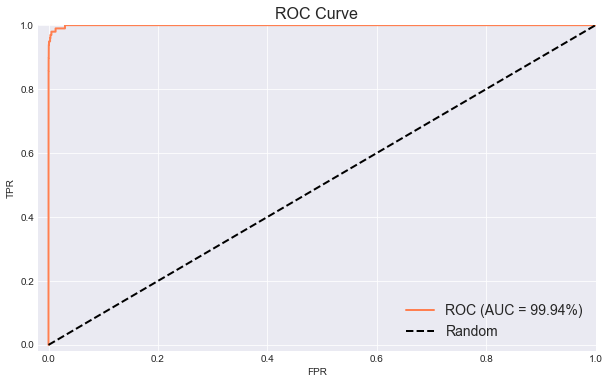


EVALUATION METRICS : XGBClassifier_RANDOM
AUC       : 99.94%
Precision : 82.24%
Recall    : 89.80%


In [44]:
#  Build the model and save the metrics obtained with RANDOM sampling
results = build_xgboost_classifier(X_train_random, y_train_random, 
                                   X_test.to_numpy(), y_test.to_numpy(), 
                                   model_name='XGBClassifier_RANDOM')
balanced_results.append(results)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 37.0min finished



CROSS VALIDATION METRICS : XGBClassifier_SMOTE
Train AUC         : 98.89% | Val AUC: 98.74%
Train Precision   : 99.32% | Val Precision: 99.05%
Train Recall      : 98.45% | Val Recall: 98.43%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 500}
Best AUC Score    : 99.94%



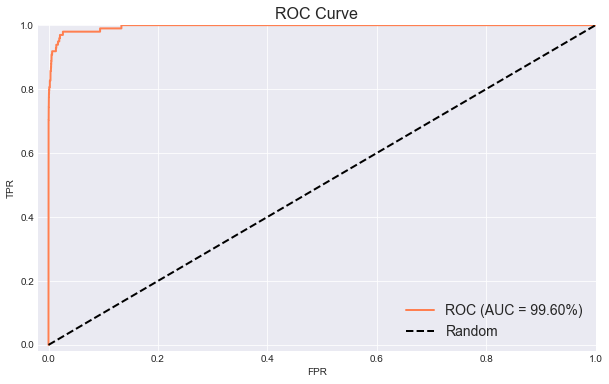


EVALUATION METRICS : XGBClassifier_SMOTE
AUC       : 99.60%
Precision : 14.85%
Recall    : 91.84%


In [48]:
#  Build the model and save the metrics obtained with SMOTE sampling
results = build_xgboost_classifier(X_train_smote, y_train_smote, 
                                   X_test.to_numpy(), y_test.to_numpy(), 
                                   model_name='XGBClassifier_SMOTE')
balanced_results.append(results)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 43.5min finished



CROSS VALIDATION METRICS : XGBClassifier_ADASYN
Train AUC         : 98.50% | Val AUC: 96.78%
Train Precision   : 98.42% | Val Precision: 98.06%
Train Recall      : 98.57% | Val Recall: 95.45%
----------------------------------------------------------------------------------------------------
Best Params       : {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 500}
Best AUC Score    : 98.54%



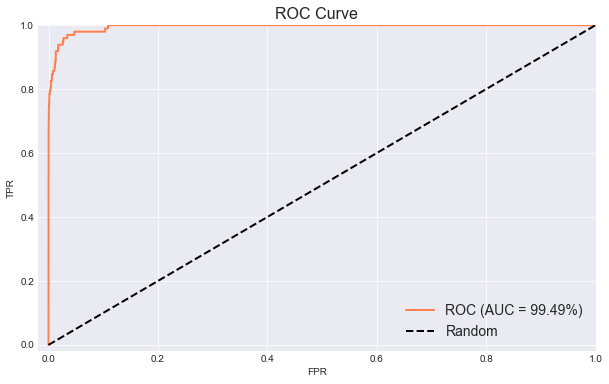


EVALUATION METRICS : XGBClassifier_ADASYN
AUC       : 99.49%
Precision : 10.97%
Recall    : 88.78%


In [52]:
#  Build the model and save the metrics obtained with ADASYN sampling
results = build_xgboost_classifier(X_train_adasyn, y_train_adasyn, 
                                   X_test.to_numpy(), y_test.to_numpy(), 
                                   model_name='XGBClassifier_ADASYN')
balanced_results.append(results)

### 4.7 Best Model - Selection

In [56]:
# Analyse the model metrics
bal_metrics_df = pd.DataFrame([balanced_results[i][1:] for i in range(15)], 
                              columns=['Model', 'auc', 'precision', 'recall'])
bal_metrics_df.iloc[:, 1:] = bal_metrics_df.iloc[:, 1:].apply(lambda x: round(x*100, 2))
bal_metrics_df['f1'] = round((2 * bal_metrics_df.precision * bal_metrics_df.recall)/(bal_metrics_df.precision + bal_metrics_df.recall), 2)
bal_metrics_df.sort_values(by=['auc','recall','precision'], ascending=False, inplace=True)
bal_metrics_df

,Model,auc,precision,recall,f1
12,XGBClassifier_RANDOM,99.94,82.24,89.80,85.85
6,RandomForestClassifier_RANDOM,99.80,76.15,84.69,80.19
8,RandomForestClassifier_ADASYN,99.76,11.11,93.88,19.87
7,RandomForestClassifier_SMOTE,99.74,37.02,88.78,52.25
13,XGBClassifier_SMOTE,99.60,14.85,91.84,25.57
14,XGBClassifier_ADASYN,99.49,10.97,88.78,19.53
11,LinearSVC_ADASYN,97.70,5.46,89.80,10.29
2,LogisticRegression_ADASYN,97.63,5.10,89.80,9.65
10,LinearSVC_SMOTE,97.58,18.87,88.78,31.12
9,LinearSVC_RANDOM,97.55,10.88,88.78,19.38


> We'd use same best model selection criterias we discussed in section "3.6 Best Model Selction" for imbalanced-dataset above.
<br> The performance metrics for balanced dataset above shows that `RandomForestClassifier` with RANDOM over sampling method has comparable AUC however `XGBClassifier` using RANDOM over-sampling gives us far better recall and precision <br><br>

#### Hence we'll choose `***XGBClassifier with RANDOM over-sampling***` as our best model for balanced dataset. This is the model that has very high AUC and it'll help us in catching maximum number of frauds (high recall) while keeping the noise of false alarms low (high precision)


### 4.8 Best Model - Feature Importances

Top var = 12
2nd Top var = 4
3rd Top var = 10


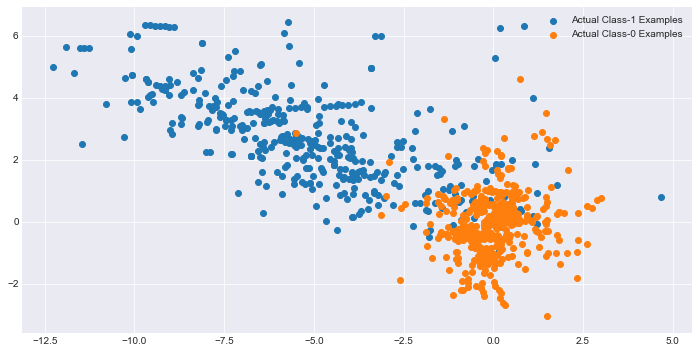

In [58]:
# XGBClassifier_RANDOM is our top tuned model for balanced dataset, lets extract it from saved results
# Which is at index 12 (13th item) in balanced_results list
clf = balanced_results[12][0]

var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-12 and Index-8 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

plt.figure(figsize=(12, 6))
plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## 5 Final Conclusion
Lets select our final model among the two best model chosen, one for imbalanced-dataset (`RandomForestClassifier`) and another for balanced-dataset (`XGBClassifier_RANDOM`)

In [60]:
m1 = metrics_df.loc[metrics_df.Model == 'RandomForestClassifier']
m2 = bal_metrics_df.loc[bal_metrics_df.Model == 'XGBClassifier_RANDOM']
pd.concat([m1, m2], axis=0)

,Model,auc,precision,recall,f1
1,RandomForestClassifier,97.20,95.18,80.61,85.23
12,XGBClassifier_RANDOM,99.94,82.24,89.80,85.85


> We observe that XGBClassifier model with oversampling outperformed the winning RandomForest model on imbalanced dataset. Also XGBoost's training time is almost ~40% less compared to RandomForest training on same size dataset.

### For this project we assume that we want balanced performance from model and we are looking for high `recall` as well as decent `precision` . Keeping this in mind we'd select ***`XGBClassifier`*** with ***RANDOM over-sampling*** as our model for detecting **'Credit Card Frauds'**